In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import asyncio
import serial

In [2]:
from dataclasses import dataclass

@dataclass
class PanelOffset:
    f00: int
    f01: int
    f10: int
    f11: int

    @staticmethod
    def zero():
        return PanelOffset(0, 0, 0, 0)

@dataclass
class PanelData:
    id: int
    f00: int
    f01: int
    f10: int
    f11: int
    offset: PanelOffset

    @staticmethod
    def zero(id: int):
        return PanelData(id, 0, 0, 0, 0, PanelOffset.zero())

    @staticmethod
    def update(pd, f00, f01, f10, f11):
        return PanelData(pd.id, f00, f01, f10, f11, pd.offset)
    
    @staticmethod
    def update_side(pd, side, value):
        if side == 4:
            return PanelData(pd.id, pd.f00, pd.f01, value, pd.f11, pd.offset)
        if side == 3:
            return PanelData(pd.id, value, pd.f01, pd.f10, pd.f11, pd.offset)
        if side == 1:
            return PanelData(pd.id, pd.f00, value, pd.f10, pd.f11, pd.offset)
        if side == 2:
            return PanelData(pd.id, pd.f00, pd.f01, pd.f10, value, pd.offset)
        print(f"invalid side: {side}")
        return pd;
    
    def create_offset(self):
        self.offset = PanelOffset(self.f00, self.f01, self.f10, self.f11)

    def to_image(self):
        return np.array([
            [self.f00 - self.offset.f00, self.f01 - self.offset.f01],
            [self.f10 - self.offset.f10, self.f11 - self.offset.f11]
        ])
        
    def get_xy(self):
        img = self.to_image()
        img_sum = np.sum(img)
        if img_sum == 0:
            return 0.5, 0.5
        x_sum = img[0][1] + img[1][1]
        y_sum = img[1][0] + img[1][1]
        x = x_sum / img_sum
        y = y_sum / img_sum
        return x, y

class PanelArray:
    panels: dict[int, PanelData]

    def __init__(self, count):
        self.panels = {};
        for i in range(count):
            self.panels.update({i: PanelData.zero(i)})

    def calibrate(self):
        for pd in self.panels:
            self.panels.get(pd).create_offset()

    def clear(self):
        for pd in self.array:
            pd = pd.zero(pd.id)

    def update(self, id, f00, f01, f10, f11):
        pd = self.panels.get(id)
        if not pd:
            print(f"update failed, invalid id: {id}")
            return
        pd.update(f00, f01, f10, f11)

    def update_side(self, id, side, value):
        pd = self.panels.get(id)
        if not pd:
            print(f"update side failed, invalid id: {id}")
            return
        self.panels.update({id: PanelData.update_side(pd, side, value)})

In [3]:
def ser_preprocess_singlepanel(data, pa):
    # format: S[1, 2, 3, 4]: int
    tokens = data.split("\n")
    tokens = [token.strip() for token in tokens]
    
    for token in tokens:
        if "\x00" in token:
            token = token.replace('\x00', '')
        if not token:
            continue
        vals = token.split(" ")
        vals = [int(v) for v in vals]
        for i, v in enumerate(vals):
            pa.update_side(0, i+1, v)

In [5]:
import time
pa = PanelArray(16)
ser = serial.Serial("COM7", 115200);
# try preprocessing for offset
for i in range(50):
    data = ser.read_all().decode('ascii')
    if data:
        ser_preprocess_singlepanel(data, pa)
    time.sleep(0.02)
pa.calibrate()
ser.close()
print(pa.panels.get(0).to_image())

[[0 0]
 [0 0]]


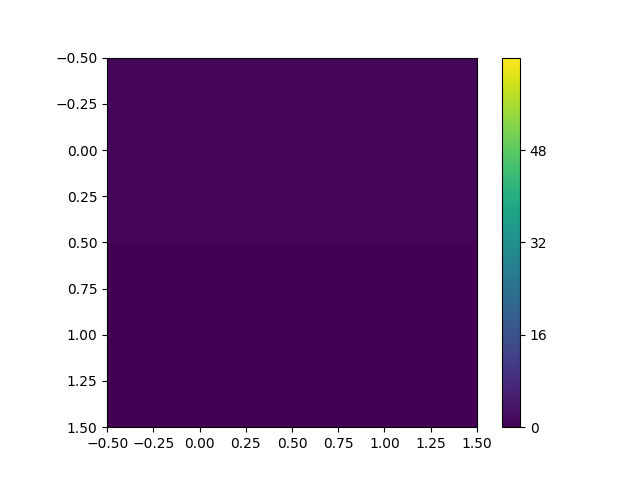

In [8]:
%matplotlib widget
fig, ax = plt.subplots()
ser.open()

async def update():
    for i in range(1000):
        data = ser.read_all().decode('ascii')
        if data:
            ser_preprocess_singlepanel(data, pa)
        plt.clf()
        cax = plt.imshow(pa.panels.get(0).to_image(), cmap='viridis', vmin=0, vmax=128)
        x, y = pa.panels.get(0).get_xy()
        plt.annotate('guess', xy=(x*2-0.5, y*2-0.5), xycoords='data',
             xytext=(0.72, 0.18), textcoords='figure fraction', color="white",
             arrowprops=dict(arrowstyle="->", color="white"))
        plt.scatter(x*2-0.5, y*2-0.5, s=100, c='red', marker='o')
        fig.canvas.draw()
        await asyncio.sleep(0.02)

    ser.close()

cax = plt.imshow(pa.panels.get(0).to_image(), cmap='viridis', vmin=0, vmax=64)
fig.colorbar(cax, ax=ax, orientation='vertical', ticks=range(0, 64, 16))
loop = asyncio.get_event_loop()
loop.create_task(update());
